In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import torch
import numpy as np

class HMM(torch.nn.Module):
  """
  Hidden Markov Model with discrete observations.
  """
  def __init__(self, N, distributions):
    super(HMM, self).__init__()
    #self.M = M # number of possible observations
    self.N = N # number of states

    # A
    self.transition_model = TransitionModel(self.N)

    # b(x_t)
    self.emission_model = EmissionModel(self.N, distributions)

    # pi
    self.unnormalized_state_priors = torch.nn.Parameter(torch.randn(self.N))

    # use the GPU
    self.is_cuda = torch.cuda.is_available()
    if self.is_cuda: self.cuda()

class TransitionModel(torch.nn.Module):
  def __init__(self, N):
    super(TransitionModel, self).__init__()
    self.N = N
    self.unnormalized_transition_matrix = torch.nn.Parameter(torch.randn(N,N))

class EmissionModel(torch.nn.Module):
  def __init__(self, N, distributions):
    super(EmissionModel, self).__init__()
    self.N = N
    self.distributions = distributions ## list of distributions

  def pdf(self, hidden_state, observation):
    current_distribution = self.distributions[hidden_state]
    return torch.exp(current_distribution.log_prob(torch.Tensor(observation)))

In [13]:
def sample(self, T=10):
  state_priors = torch.nn.functional.softmax(self.unnormalized_state_priors, dim=0)
  transition_matrix = torch.nn.functional.softmax(self.transition_model.unnormalized_transition_matrix, dim=0)
  #emission_matrix = torch.nn.functional.softmax(self.emission_model.unnormalized_emission_matrix, dim=1)

  # sample initial state
  z_t = torch.distributions.categorical.Categorical(state_priors).sample().item()
  z = []; x = []
  z.append(z_t)
  for t in range(0,T):
    # sample emission
    # x_t = torch.distributions.categorical.Categorical(emission_matrix[z_t]).sample().item()
    current_distribution = self.emission_model.distributions[z_t]
    x_t = current_distribution.sample()
    x.append(x_t)

    # sample transition
    z_t = torch.distributions.categorical.Categorical(transition_matrix[:,z_t]).sample().item()
    if t < T-1: z.append(z_t)
 
  return torch.stack(x), z

# Add the sampling method to our HMM class
HMM.sample = sample

In [14]:
class TriangleDistribution(distrib.uniform.Uniform):
    def __init__(self, noise_sd=0.01, validate_args=None):
        super().__init__(0, 2*(1 + 2**0.5), validate_args)
        self.noise_distribution = distrib.Normal(0,noise_sd)

    def sample(self, sample_shape=torch.Size([])):
        line = super().sample(sample_shape)
        base = line <= 2
        left_arm = (line <= 2 + 2**0.5) * (line > 2)
        right_arm = line > 2 + 2**0.5
        triangle = torch.stack([line * base, torch.zeros(sample_shape)], dim=-1)
        left_arm_coord = left_arm * (line - 2.) / 2**0.5
        triangle += torch.stack([left_arm_coord, left_arm_coord], dim=-1)
        right_arm_coord = right_arm * ((line - (2 + 2**0.5)) / 2**0.5 + 1)
        right_arm_coord_y = right_arm * (1 - (line - (2 + 2**0.5)) / 2**0.5)
        triangle += torch.stack([right_arm_coord, right_arm_coord_y], dim=-1)
        return triangle + torch.stack([self.noise_distribution.sample(sample_shape), self.noise_distribution.sample(sample_shape)], dim=-1)

    def plot(self, T=400):
        samples = self.sample([T])
        plt.scatter(samples[:,0], samples[:,1])

In [15]:
class CircleDistribution(distrib.uniform.Uniform):
    def __init__(self, radious, center, noise_sd=0.01, validate_args=None):
        super().__init__(0, 2 * np.pi, validate_args)
        self.noise_distribution = distrib.Normal(0,noise_sd)
        self.radious = radious
        self.center = center

    def sample(self, sample_shape=torch.Size([])):
        line = super().sample(sample_shape)
        x = self.radious * torch.cos(line) + self.center[0]
        y = self.radious * torch.sin(line) + self.center[1]

        return torch.stack([x,y], dim=-1) + torch.stack([self.noise_distribution.sample(sample_shape), 
                                                         self.noise_distribution.sample(sample_shape)], dim=-1)

    def plot(self, T=400):
        samples = self.sample([T])
        plt.scatter(samples[:,0], samples[:,1])

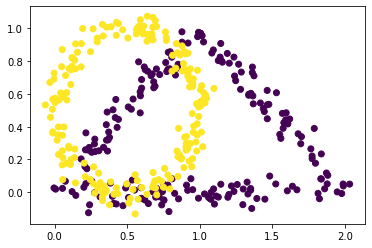

In [16]:
device = 'cpu'
n=200
triangle_generator = TriangleDistribution(noise_sd=0.05)
triangle_sample = triangle_generator.sample([n])

device = 'cpu'
circle_generator = CircleDistribution(torch.tensor(0.5), torch.tensor([0.5,0.5]), noise_sd=0.05)
circle_sample = circle_generator.sample([n])

category = torch.tensor([0]*200 + [1] * 200)

dataset = torch.cat([triangle_sample, circle_sample])

plt.scatter(dataset[:,0], dataset[:,1], c=category)


In [30]:
import torch
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ArtificialDataset(torch.utils.data.Dataset):
    def __init__(self, distributions, device, T=1000):
        self.device = device

        self.T = T
        self.MyHMM = HMM(len(distributions), distributions)
        self.generate_sequence()

    def generate_sequence(self):
        X, Z = self.MyHMM.sample(self.T)
        self.train_X = X
        self.train_Z = Z

        X, Z = self.MyHMM.sample(int(0.2*self.T))
        self.test_X = X
        self.test_Z = Z

    def __len__(self):
        return self.T

    def __getitem__(self, index):
        return (
            self.train_X[index],
        )
        
my_dataset = ArtificialDataset([triangle_generator, circle_generator], 'cpu')

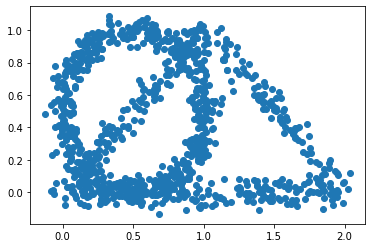

In [31]:
samples = my_dataset[1:len(my_dataset)][0]
plt.scatter(samples[:,0], samples[:,1])

## Code to copy

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class HMM(torch.nn.Module):
  """
  Hidden Markov Model with discrete observations.
  """
  def __init__(self, N, distributions):
    super(HMM, self).__init__()
    #self.M = M # number of possible observations
    self.N = N # number of states

    # A
    self.transition_model = TransitionModel(self.N)

    # b(x_t)
    self.emission_model = EmissionModel(self.N, distributions)

    # pi
    self.unnormalized_state_priors = torch.nn.Parameter(torch.randn(self.N))

    # use the GPU
    self.is_cuda = torch.cuda.is_available()
    if self.is_cuda: self.cuda()

class TransitionModel(torch.nn.Module):
  def __init__(self, N):
    super(TransitionModel, self).__init__()
    self.N = N
    self.unnormalized_transition_matrix = torch.nn.Parameter(torch.randn(N,N))

class EmissionModel(torch.nn.Module):
  def __init__(self, N, distributions):
    super(EmissionModel, self).__init__()
    self.N = N
    self.distributions = distributions ## list of distributions

  def pdf(self, hidden_state, observation):
    current_distribution = self.distributions[hidden_state]
    return torch.exp(current_distribution.log_prob(torch.Tensor(observation)))

In [4]:
def sample(self, T=10):
  state_priors = torch.nn.functional.softmax(self.unnormalized_state_priors, dim=0)
  transition_matrix = torch.nn.functional.softmax(self.transition_model.unnormalized_transition_matrix, dim=0)
  #emission_matrix = torch.nn.functional.softmax(self.emission_model.unnormalized_emission_matrix, dim=1)

  # sample initial state
  z_t = torch.distributions.categorical.Categorical(state_priors).sample().item()
  z = []; x = []
  z.append(z_t)
  for t in range(0,T):
    # sample emission
    # x_t = torch.distributions.categorical.Categorical(emission_matrix[z_t]).sample().item()
    current_distribution = self.emission_model.distributions[z_t]
    x_t = current_distribution.sample()
    x.append(x_t)

    # sample transition
    z_t = torch.distributions.categorical.Categorical(transition_matrix[:,z_t]).sample().item()
    if t < T-1: z.append(z_t)
 
  return torch.stack(x), z

# Add the sampling method to our HMM class
HMM.sample = sample

In [5]:
class TriangleDistribution(distrib.uniform.Uniform):
    def __init__(self, noise_sd=0.01, validate_args=None):
        super().__init__(0, 2*(1 + 2**0.5), validate_args)
        self.noise_distribution = distrib.Normal(0,noise_sd)

    def sample(self, sample_shape=torch.Size([])):
        line = super().sample(sample_shape)
        base = line <= 2
        left_arm = (line <= 2 + 2**0.5) * (line > 2)
        right_arm = line > 2 + 2**0.5
        triangle = torch.stack([line * base, torch.zeros(sample_shape)], dim=-1)
        left_arm_coord = left_arm * (line - 2.) / 2**0.5
        triangle += torch.stack([left_arm_coord, left_arm_coord], dim=-1)
        right_arm_coord = right_arm * ((line - (2 + 2**0.5)) / 2**0.5 + 1)
        right_arm_coord_y = right_arm * (1 - (line - (2 + 2**0.5)) / 2**0.5)
        triangle += torch.stack([right_arm_coord, right_arm_coord_y], dim=-1)
        return triangle + torch.stack([self.noise_distribution.sample(sample_shape), self.noise_distribution.sample(sample_shape)], dim=-1)

    def plot(self, T=400):
        samples = self.sample([T])
        plt.scatter(samples[:,0], samples[:,1])

In [6]:
class CircleDistribution(distrib.uniform.Uniform):
    def __init__(self, radious, center, noise_sd=0.01, validate_args=None):
        super().__init__(0, 2 * np.pi, validate_args)
        self.noise_distribution = distrib.Normal(0,noise_sd)
        self.radious = radious
        self.center = center

    def sample(self, sample_shape=torch.Size([])):
        line = super().sample(sample_shape)
        x = self.radious * torch.cos(line) + self.center[0]
        y = self.radious * torch.sin(line) + self.center[1]

        return torch.stack([x,y], dim=-1) + torch.stack([self.noise_distribution.sample(sample_shape), 
                                                         self.noise_distribution.sample(sample_shape)], dim=-1)

    def plot(self, T=400):
        samples = self.sample([T])
        plt.scatter(samples[:,0], samples[:,1])

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ArtificialDataset(torch.utils.data.Dataset):
    def __init__(self, distributions, device, T=1000):
        self.device = device

        self.T = T
        self.MyHMM = HMM(len(distributions), distributions)
        self.generate_sequence()

    def generate_sequence(self):
        X, Z = self.MyHMM.sample(self.T)
        self.train_X = X
        self.train_Z = Z

        X, Z = self.MyHMM.sample(int(0.2*self.T))
        self.test_X = X
        self.test_Z = Z

    def __len__(self):
        return self.T

    def __getitem__(self, index):
        t = self.train_X[index]
        t.to(device)
        return t

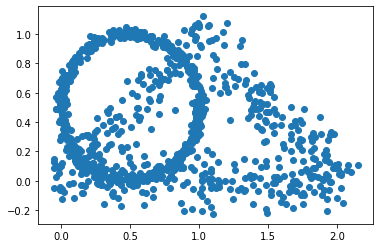

In [11]:
triangle_generator = TriangleDistribution(noise_sd=0.1)
circle_generator = CircleDistribution(torch.tensor(0.5), torch.tensor([0.5,0.5]), noise_sd=0.02)
my_dataset = ArtificialDataset([triangle_generator, circle_generator], device)

samples = my_dataset[1:len(my_dataset)]
plt.scatter(samples[:,0], samples[:,1])